# Calculating yields

In [10]:
from cameo import load_model, fba
model_original = load_model('data/iJO1366.xml.gz')

## Product yield

In [11]:
model = model_original.copy()

Calculating the yield of a product is straigtforward. First one sets the producing reaction a new objective of the model.

In [12]:
model.objective = model.reactions.EX_ac_e

Then one determines the maximum production flux by solving the model.

In [13]:
model.solve()
model.reactions.EX_ac_e.flux

29.093467336683354

Dividing the production flux by the uptake flux of the carbon source (in this case glucose) yields the molar yield (mol product / mol glucose).

In [14]:
model.reactions.EX_ac_e.flux / (-1. * model.reactions.EX_glc__D_e.flux)

2.909346733668335

## Exercise

* Convert the yield into a C-mol (product) / C-mol (carbon source) yield.
* Calculate a mass yield instead of molar yield (g (product) / g (carbon source))

In [15]:
(model.reactions.EX_ac_e.flux * model.metabolites.ac_c.elements['C']) / (-1. * model.reactions.EX_glc__D_e.flux * model.metabolites.glc__D_e.elements['C'])

0.9697822445561118

In [16]:
(model.reactions.EX_ac_e.flux * model.metabolites.ac_c.formula_weight) / (-1. * model.reactions.EX_glc__D_e.flux * model.metabolites.glc__D_e.formula_weight)

0.9535049687506613

## Biomass yield

In [18]:
model = model_original.copy()

In [19]:
model.solve()
gDW_biomass_per_mmol_glucose = model.reactions.BIOMASS_Ec_iJO1366_core_53p95M.flux / (-1. * model.reactions.EX_glc__D_e.flux)
gDW_biomass_per_mmol_glucose

0.09823718127269779

The units of this yield are gDW (Biomass) / mmol (glucose). We can convert this number into a mass yield by doing the following conversion.

In [20]:
gDW_biomass_per_g_glucose = gDW_biomass_per_mmol_glucose * (1000 / model.metabolites.glc__D_e.formula_weight)
gDW_biomass_per_g_glucose

0.5452898971307392

# Growth vs. Product yield

In [21]:
model = model_original.copy()

In the previous section we calculated theoretical maximum yields in the absence of competing objectives. But how does product yield vary with growth for example?

In [22]:
from numpy import array, linspace

In [23]:
growth_rates = linspace(0, model.solve().objective_value , 10)
growth_rates

array([ 0.        ,  0.10915242,  0.21830485,  0.32745727,  0.43660969,
        0.54576212,  0.65491454,  0.76406697,  0.87321939,  0.98237181])

In [24]:
product_fluxes = []
model.objective = model.reactions.EX_ac_e
for growth in growth_rates:
    model.reactions.BIOMASS_Ec_iJO1366_core_53p95M.change_bounds(growth, growth)
    product_fluxes.append(model.solve().objective_value)
product_fluxes = array(product_fluxes)

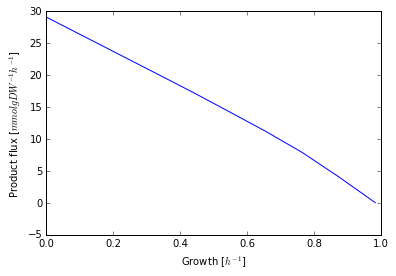

In [26]:
import matplotlib.pyplot as plt
plt.plot(growth_rates, product_fluxes)
plt.xlabel('Growth [$h^{-1}$]')
plt.ylabel('Product flux [$mmol gDW^{-1} h^{-1}$]')
plt.show()

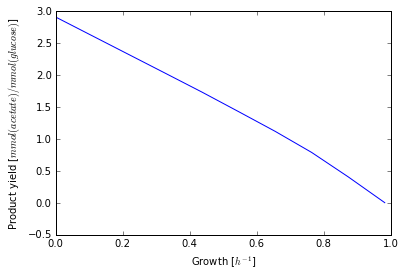

In [27]:
plt.plot(growth_rates, product_fluxes / (-1 * model.reactions.EX_glc__D_e.flux))
plt.xlabel('Growth [$h^{-1}$]')
plt.ylabel('Product yield [$mmol(acetate) / mmol(glucose)$]')
plt.show()

Luckily, cameo provides a function for calculating phenotypic planes. For example, let's compute again the phenotypic phase plane for growth and acetate secretion.

In [28]:
from cameo import phenotypic_phase_plane

In [29]:
model = model_original.copy()

In [30]:
result = phenotypic_phase_plane(model,
                                variables=[model.reactions.BIOMASS_Ec_iJO1366_core_53p95M],
                                objective=model.reactions.EX_ac_e)

Look at the result in a tabular view.

In [31]:
result.data_frame

,BIOMASS_Ec_iJO1366_core_53p95M,objective_lower_bound,objective_upper_bound
0,0.982372,0.0,-1.007779e-13
1,0.930668,0.0,1.917814e+00
2,0.878964,0.0,3.835628e+00
3,0.827260,0.0,5.753441e+00
...,...,...,...
16,0.155111,0.0,2.491990e+01
17,0.103408,0.0,2.631109e+01
18,0.051704,0.0,2.770228e+01
19,0.000000,0.0,2.909347e+01


Plot the phenotypic phase plane.

In [32]:
result.plot()

We can also calculate a three dimensional phenotypic phase plane to compare the influence of aerobic and anaerobic environements.

In [36]:
%%time
result_3D = phenotypic_phase_plane(model,
                                   variables=[model.reactions.EX_ac_e, model.reactions.EX_o2_e],
                                   objective=model.reactions.BIOMASS_Ec_iJO1366_core_53p95M)

CPU times: user 1min 37s, sys: 682 ms, total: 1min 38s
Wall time: 1min 41s


In [26]:
result_3D.data_frame

,EX_ac_e,EX_o2_e,objective_lower_bound,objective_upper_bound
0,0.0,-6.000000e+01,0.0,-4.842084e-17
1,0.0,-5.877551e+01,0.0,2.801293e-02
2,0.0,-5.755102e+01,0.0,5.602585e-02
3,0.0,-5.632653e+01,0.0,8.403878e-02
4,0.0,-5.510204e+01,0.0,1.120517e-01
5,0.0,-5.387755e+01,0.0,1.400646e-01
...,...,...,...,...
2494,20.0,-6.122449e+00,0.0,0.000000e+00
2495,20.0,-4.897959e+00,0.0,0.000000e+00
2496,20.0,-3.673469e+00,0.0,0.000000e+00


Unfortunately, 3D plots are not yet supported out of the box.

In [18]:
result_3D.plot()

So let's quickly write a custom plot (you can use your mouse to rotate the graphic).

In [27]:
%matplotlib notebook

<IPython.core.display.Javascript object>


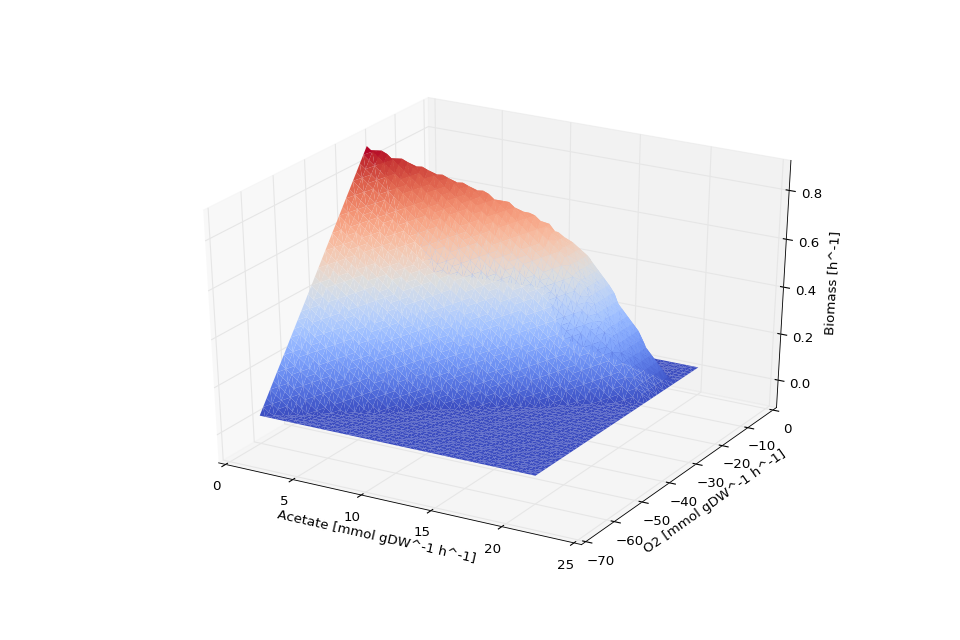

In [28]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(
    result_3D.data_frame.EX_ac_e.values,
    result_3D.data_frame.EX_o2_e.values,
    result_3D.data_frame.objective_upper_bound.values,
    cmap=cm.coolwarm, linewidth=0, antialiased=True)
ax.set_xlabel('Acetate [mmol gDW^-1 h^-1]')
ax.set_ylabel('O2 [mmol gDW^-1 h^-1]')
ax.set_zlabel('Biomass [h^-1]')
ax.mouse_init()
# interact(f(fig, ax), angle=(0, 360), elevation=(-100, 100))